In [1]:
%config Completer.use_jedi = False
import sys
import warnings
warnings.filterwarnings('ignore')

import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

2023-01-29 23:16:28.093038: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-29 23:16:28.273572: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-01-29 23:16:28.917928: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /end/home/rh2310/lib:/end/soft/Linux_2.6_64/lib::/end/home/rh2310/.conda/envs/tensorflo

In [2]:
MEMORY = 12*1024

gpus = tf.config.list_physical_devices('GPU')
try:
    tf.config.set_logical_device_configuration(gpus[0],
                                              [tf.config.LogicalDeviceConfiguration(memory_limit=MEMORY)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
except RuntimeError as e:        
    # Memory growth must be set before GPUs have been initialized
    print(e) 

1 Physical GPUs, 1 Logical GPUs


2023-01-29 23:16:39.295241: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-29 23:16:39.878885: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 12288 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:e3:00.0, compute capability: 8.6


In [3]:
import pathlib
import pickle
import ipywidgets as widgets
from IPython.display import display
from IPython.display import clear_output
from ipywidgets.widgets import HBox, VBox, Label
from pathlib import Path
sys.path.append(f"{Path.home()}/morpho_repo")
sys.path.append(f"{Path.home()}/morpho_repo/turing_codebase")
from turing.utils import *
from turing.tf_utils import *
import turing.pinns as tu
from turing.loss_functions import *

In [4]:
from local_utils import *

# Load Koch Meinhardt dataset


In [5]:
def loss(u, u_xx, u_yy, u_t, v, v_xx, v_yy, v_t, params):
    D_u = params["D_u"]
    D_v = params["D_v"]
    sigma_u = params["sigma_u"]
    sigma_v = params["sigma_v"]
    mu_u = params["mu_u"]
    rho_u = params["rho_u"]
    rho_v = params["rho_v"]
    kappa_u = params["kappa_u"]

    f = u * u * v / (1.0 + kappa_u * u * u)
    f_u = (D_u * (u_xx + u_yy) 
           + rho_u * f 
           - mu_u * u 
           + sigma_u
           - u_t)
    f_v =( D_v * (v_xx + v_yy)
         - rho_v * f 
         + sigma_v
         - v_t)
    return (f_u, f_v, f, D_u * (u_xx + u_yy) , D_v * (v_xx + v_yy))


def RMSE_loss(u, u_xx, u_yy, u_t, v,  v_xx, v_yy, v_t, params):
    f_u, f_v, _, _ , _ = loss(u,  u_xx, u_yy, u_t, v,  v_xx, v_yy, v_t, params)
    return np.sqrt( np.mean(np.concatenate([f_u, f_v])**2) )



In [57]:
sim_names = ["Koch_Meinhardt_1", "Koch_Meinhardt_2", "Koch_Meinhardt_3",
             "Koch_Meinhardt_4", "Koch_Meinhardt_5",
             "Koch_Meinhardt_6", "Koch_Meinhardt_7", "Koch_Meinhardt_9"]
x_slice=slice(30,65,1)
y_slice=slice(50,85,1)

sim_name = sim_names[3]
print(sim_name)
pattern = load(sim_name, x_slice, y_slice)
lb = pattern.dataset['lb']
ub = pattern.dataset['ub']

obs_inputs = pattern.dataset['obs_input']
obs_outputs = pattern.dataset['obs_output']
obs_X = np.concatenate([obs_inputs, obs_outputs], axis=1)
pde_X = obs_inputs
ds = TINN_Dataset(tf.float32, pde_X)
params_ac = pattern.params
    
simulation = pattern.simulation
path_template =  f"saved_models/{sim_name}_pinn_step_{x_slice.step}"
pinnKM = tu.NN.restore(".", path_template)
obs_loss = Observation_Loss(pinnKM.layers,regularise=True, loss_grad_type=  Loss_Grad_Type.PINN)    
    
@tf.function
def derivatives(pinn, x):
    return obs_loss.derivatives(pinn, x)

test_X = obs_X[:,:3].astype(np.float32)
_, u,  u_xx, u_yy, u_t, v,  v_xx, v_yy, v_t = derivatives(pinnKM, test_X)

 
block_x = pattern.block_x
block_y = pattern.block_y
block_size = block_x * block_y
def to_2D(m, block_x, block_y):
    block_size = block_x * block_y
    if isinstance(m, np.ndarray):
        return m[block_size:].reshape(block_x, block_y).T
    else:
        return m.numpy()[block_size:].reshape(block_x, block_y).T    
    

u_ac = pattern.dataset['obs_output'][:, 0]
v_ac = pattern.dataset['obs_output'][:, 1]
u_xx_ac = pattern.dataset['der_u'][0,:]  
u_yy_ac = pattern.dataset['der_u'][1,:]
u_t_ac = pattern.dataset['der_u'][2,:]
v_xx_ac = pattern.dataset['der_v'][0,:]  
v_yy_ac = pattern.dataset['der_v'][1,:]
v_t_ac = pattern.dataset['der_v'][2,:]
u_diff_ac = (u_xx_ac + u_yy_ac)
v_diff_ac = (v_xx_ac + v_yy_ac)    

u_diff = (u_xx + u_yy)
v_diff = (v_xx + v_yy)


Koch_Meinhardt_4


In [58]:
def to_2D(m, block_x, block_y):
    block_size = block_x * block_y
    if isinstance(m, np.ndarray):
        return m[:block_size].reshape(block_x, block_y).T
    else:
        return m.numpy()[:block_size].reshape(block_x, block_y).T

In [59]:
def plot_slice(valid, actual, x, y, x_range, y_range, scale_factor, t1="U(X)", t2="U(Y)", x_index = 0, y_index = 0):
    fig=plt.figure(figsize=(12, 8))
    gs = fig.add_gridspec(3, 2)
    ax = fig.add_subplot(gs[0, 0])
    img = ax.contourf(x_range,y_range ,valid, origin='lower')
    plt.colorbar(img, ax=ax)
    ax.vlines(x_range[x_index*scale_factor], y_range[0], y_range[-1], color='r')
    ax.hlines(y_range[y_index*scale_factor], x_range[0], x_range[-1], color='r')

    ax = fig.add_subplot(gs[0, 1])
    img = ax.imshow(valid, origin='lower')
    plt.colorbar(img, ax=ax)

    ax=fig.add_subplot(gs[1, :])
    ax2=fig.add_subplot(gs[1, :], frame_on=False)
    ax.plot(x_range,valid[:, x_index*scale_factor])
    ax.set_ylim([np.min(valid), np.max(valid)*1.05])
    ax.set_ylabel(t1)
    ax2.plot(x, actual[:, x_index], 'x',c='r')
    ax2.set_ylim([np.min(actual), np.max(actual)*1.05])
    ax2.xaxis.tick_top()
    ax2.yaxis.tick_right()

    ax=fig.add_subplot(gs[2, :])
    ax2=fig.add_subplot(gs[2, :], frame_on=False)
    ax.plot(y_range,valid[y_index*scale_factor, :])
    ax.set_ylim([np.min(valid), np.max(valid)*1.05])
    ax.set_ylabel(t2)
    ax2.plot(y, actual[y_index, :], 'x',c='r')
    ax2.set_ylim([np.min(actual), np.max(actual)*1.05])
    ax2.xaxis.tick_top()
    ax2.yaxis.tick_right()
    plt.tight_layout()
    plt.show()
    
def create_index_slider(title='x index:', max=10):
    return widgets.IntSlider(
            value=0,
            min=0,
            max=max,
            step=1,
            description=title,
            continuous_update=False,
        )

In [60]:
x = np.unique(pattern.dataset['obs_input'][:,0])
y = np.unique(pattern.dataset['obs_input'][:,1])

outputs = pattern.dataset['obs_output'].astype(np.float32)
u = to_2D(outputs[:,0], pattern.block_x, pattern.block_x)
v = to_2D(outputs[:,1], pattern.block_x, pattern.block_x)

scale_factor = 20
x_range = np.concatenate([np.linspace(x1,x2, scale_factor+1)[:-1] for x1, x2 in zip(x[:-1], x[1:])] + [[x[-1]]])
y_range = np.concatenate([np.linspace(y1,y2, scale_factor+1)[:-1] for y1, y2 in zip(y[:-1], y[1:])] + [[y[-1]]])
                   

X,Y = np.meshgrid(x_range, y_range, indexing='ij')
t_range = np.repeat(pattern.t_star[-1], X.shape[0]*X.shape[1]).astype(np.float32)

x_validate = np.concatenate([X.flatten()[:, np.newaxis], 
                             Y.flatten()[:, np.newaxis], 
                             t_range[:, np.newaxis]], axis=1).astype(np.float32)



outputs_valid = pinnKM.net(x_validate)#pattern.dataset['obs_input'].astype(np.float32))#x_validate)
block_x = x_range.shape[0]
block_y = y_range.shape[0]
u_valid = to_2D(outputs_valid[:,0], block_x, block_y)
v_valid = to_2D(outputs_valid[:,1], block_x, block_y)

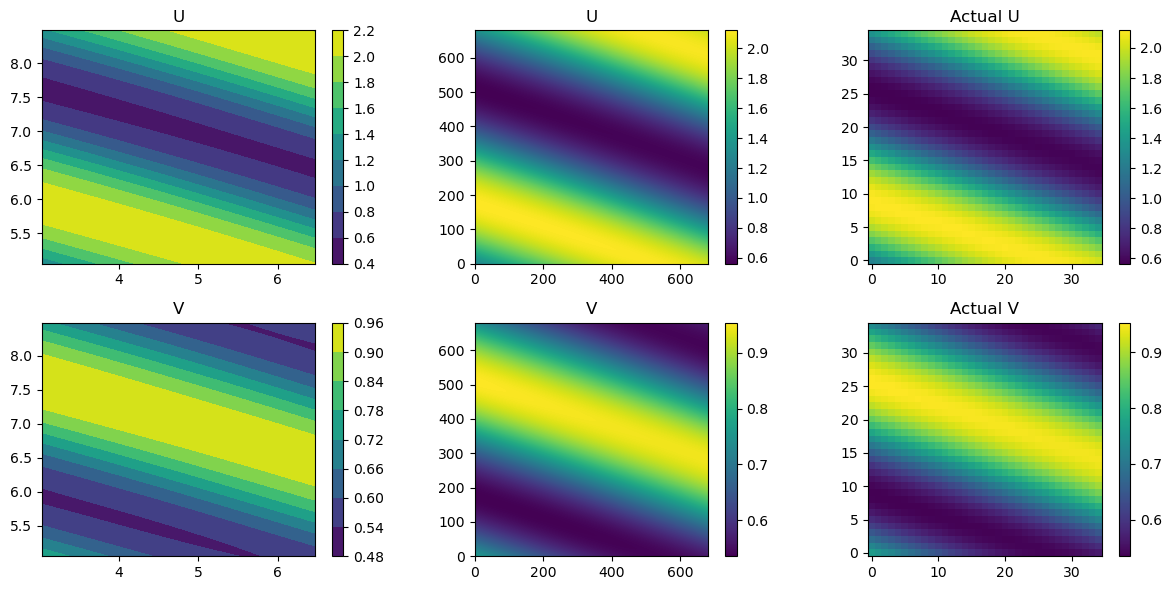

In [61]:
_ = plt.figure(figsize=(12,6))
plt.subplot(231)
plt.title("U")
plt.contourf(x_range,y_range ,u_valid, origin='lower')
plt.colorbar()
plt.subplot(232)
plt.title("U")
plt.imshow(u_valid, origin='lower')
plt.colorbar()
plt.subplot(233)
plt.title("Actual U")
plt.imshow(u, origin='lower')
plt.colorbar()
plt.subplot(234)
plt.title("V")
plt.contourf(x_range,y_range, v_valid, origin='lower')
plt.colorbar()
plt.subplot(235)
plt.title("V")
plt.imshow(v_valid, origin='lower')
plt.colorbar()
plt.subplot(236)
plt.title("Actual V")
plt.imshow(v, origin='lower')
plt.colorbar()
plt.tight_layout()
plt.show()

In [62]:
w_x_index = create_index_slider('x index:',x.shape[0]-1)
w_y_index = create_index_slider('y index:',y.shape[0]-1)

def create_plot_slice(valid, actual, x, y, x_range, y_range, scale_factor, t1, t2):
    def plot_slice_c(x_index = 0, y_index = 0):
        return plot_slice(valid, actual, x, y, x_range, y_range, scale_factor, t1, t2, x_index, y_index)
    
    return plot_slice_c
    

w_interpolate_plot = widgets.interactive_output(create_plot_slice(u_valid, u, x, y, 
                                                                  x_range, y_range, 
                                                                  scale_factor, "U(x)", "U(y)"), 
                                    {'x_index':w_x_index,
                                     'y_index': w_y_index})



h_box_indices = HBox([w_x_index, w_y_index])
hbox_w_interpolate_plot = HBox([w_interpolate_plot])
vbox_items = VBox([h_box_indices, hbox_w_interpolate_plot])
display(vbox_items)

In [63]:
w2_x_index = create_index_slider('x index:',x.shape[0]-1)
w2_y_index = create_index_slider('y index:',y.shape[0]-1)
    

w2_interpolate_plot = widgets.interactive_output(create_plot_slice(v_valid, v, x, y, 
                                                                  x_range, y_range, 
                                                                  scale_factor, "V(x)", "V(y)"), 
                                    {'x_index':w2_x_index,
                                     'y_index': w2_y_index})



h2_box_indices = HBox([w2_x_index, w2_y_index])
h2box_w_interpolate_plot = HBox([w2_interpolate_plot])
v2box_items = VBox([h2_box_indices, h2box_w_interpolate_plot])
display(v2box_items)

In [64]:
outputs_u_xxyy = pattern.dataset['der_u'][0:2, :].astype(np.float32)
u_xx = to_2D(outputs_u_xxyy[0, :], pattern.block_x, pattern.block_x)
u_yy = to_2D(outputs_u_xxyy[1, :], pattern.block_x, pattern.block_x)
outputs_v_xxyy = pattern.dataset['der_v'][0:2, :].astype(np.float32)
v_xx = to_2D(outputs_v_xxyy[0, :], pattern.block_x, pattern.block_x)
v_yy = to_2D(outputs_v_xxyy[1, :], pattern.block_x, pattern.block_x)

(_, _,  u_xx_valid , u_yy_valid , u_t_valid,
 _,  v_xx_valid , v_yy_valid , v_t_valid)  = derivatives(pinnKM, x_validate)

block_x = x_range.shape[0]
block_y = y_range.shape[0]
u_xx_valid  = to_2D(u_xx_valid , block_x, block_y)
u_yy_valid  = to_2D(u_yy_valid , block_x, block_y)
v_xx_valid  = to_2D(v_xx_valid , block_x, block_y)
v_yy_valid  = to_2D(v_yy_valid , block_x, block_y)

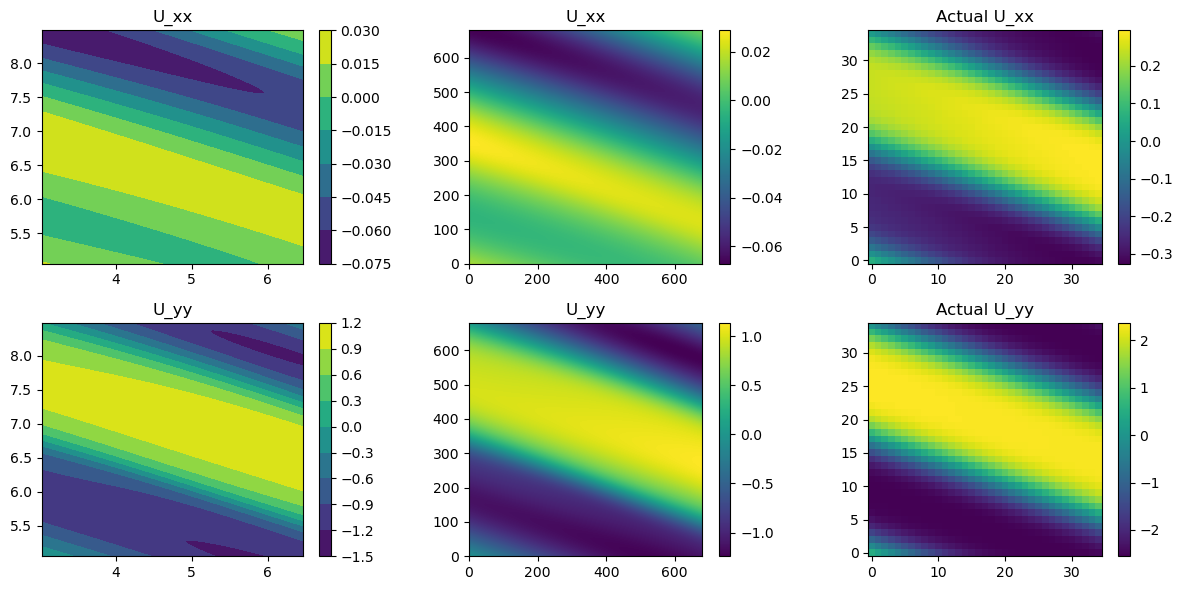

In [65]:
_ = plt.figure(figsize=(12,6))
plt.subplot(231)
plt.title("U_xx")
plt.contourf(x_range,y_range ,u_xx_valid , origin='lower')
plt.colorbar()
plt.subplot(232)
plt.title("U_xx")
plt.imshow(u_xx_valid , origin='lower')
plt.colorbar()
plt.subplot(233)
plt.title("Actual U_xx")
plt.imshow(u_xx , origin='lower')
plt.colorbar()
plt.subplot(234)
plt.title("U_yy")
plt.contourf(x_range,y_range, u_yy_valid , origin='lower')
plt.colorbar()
plt.subplot(235)
plt.title("U_yy")
plt.imshow(u_yy_valid , origin='lower')
plt.colorbar()
plt.subplot(236)
plt.title("Actual U_yy")
plt.imshow(u_yy , origin='lower')
plt.colorbar()
plt.tight_layout(); plt.show()

In [66]:
w3_x_index = create_index_slider('x index:',x.shape[0]-1)
w3_y_index = create_index_slider('y index:',y.shape[0]-1)
    
w3_interpolate_plot = widgets.interactive_output(create_plot_slice(u_xx_valid, u_xx, x, y, 
                                                                  x_range, y_range, 
                                                                  scale_factor, "U_xx(x)", "U_xx(y)"), 
                                    {'x_index':w3_x_index,
                                     'y_index': w3_y_index})


h3_box_indices = HBox([w3_x_index, w3_y_index])
h3box_w_interpolate_plot = HBox([w3_interpolate_plot])
v3box_items = VBox([h3_box_indices, h3box_w_interpolate_plot])
display(v3box_items)

In [67]:
w4_x_index = create_index_slider('x index:',x.shape[0]-1)
w4_y_index = create_index_slider('y index:',y.shape[0]-1)
    
w4_interpolate_plot = widgets.interactive_output(create_plot_slice(u_yy_valid, u_yy, x, y, 
                                                                  x_range, y_range, 
                                                                  scale_factor, "U_yy(x)", "U_yy(y)"), 
                                    {'x_index':w4_x_index,
                                     'y_index': w4_y_index})


h4_box_indices = HBox([w4_x_index, w4_y_index])
h4box_w_interpolate_plot = HBox([w4_interpolate_plot])
v4box_items = VBox([h4_box_indices, h4box_w_interpolate_plot])
display(v4box_items)

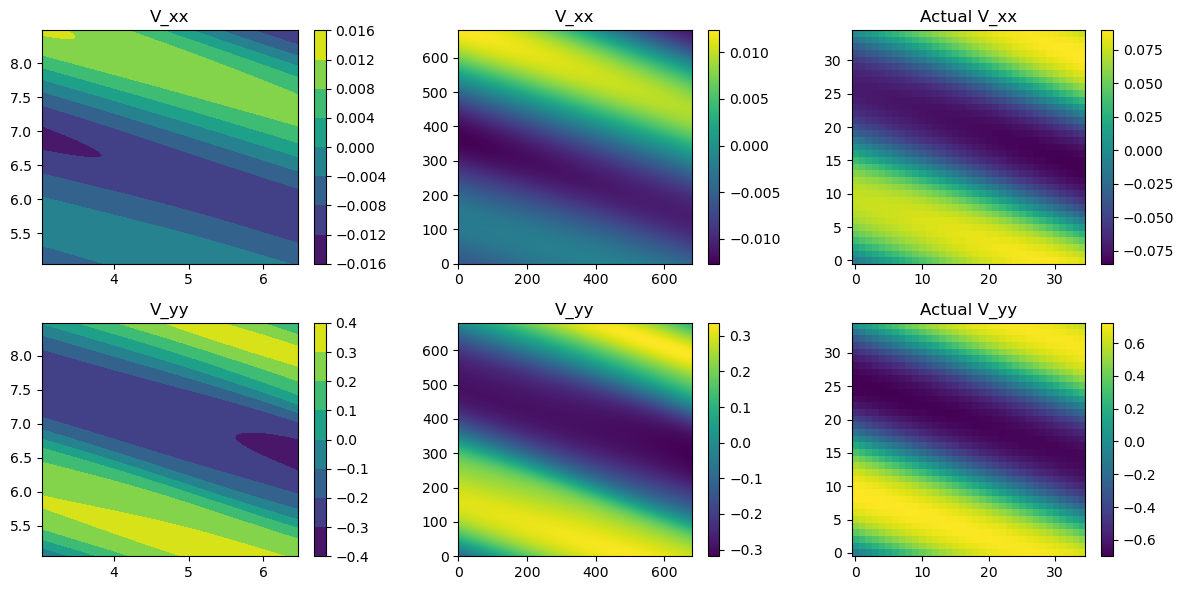

In [68]:
_ = plt.figure(figsize=(12,6))
plt.subplot(231)
plt.title("V_xx")
plt.contourf(x_range,y_range ,v_xx_valid , origin='lower')
plt.colorbar()
plt.subplot(232)
plt.title("V_xx")
plt.imshow(v_xx_valid , origin='lower')
plt.colorbar()
plt.subplot(233)
plt.title("Actual V_xx")
plt.imshow(v_xx , origin='lower')
plt.colorbar()
plt.subplot(234)
plt.title("V_yy")
plt.contourf(x_range,y_range, v_yy_valid , origin='lower')
plt.colorbar()
plt.subplot(235)
plt.title("V_yy")
plt.imshow(v_yy_valid , origin='lower')
plt.colorbar()
plt.subplot(236)
plt.title("Actual V_yy")
plt.imshow(v_yy , origin='lower')
plt.colorbar()
plt.tight_layout(); plt.show()

In [69]:
w5_x_index = create_index_slider('x index:',x.shape[0]-1)
w5_y_index = create_index_slider('y index:',y.shape[0]-1)
    
w5_interpolate_plot = widgets.interactive_output(create_plot_slice(v_xx_valid, v_xx, x, y, 
                                                                  x_range, y_range, 
                                                                  scale_factor, "V_xx(X)", "V_xx(Y)"), 
                                    {'x_index':w5_x_index,
                                     'y_index': w5_y_index})


h5_box_indices = HBox([w5_x_index, w5_y_index])
h5box_w_interpolate_plot = HBox([w5_interpolate_plot])
v5box_items = VBox([h5_box_indices, h5box_w_interpolate_plot])
display(v5box_items)

In [70]:
w6_x_index = create_index_slider('x index:',x.shape[0]-1)
w6_y_index = create_index_slider('y index:',y.shape[0]-1)
    
w6_interpolate_plot = widgets.interactive_output(create_plot_slice(v_yy_valid, v_yy, x, y, 
                                                                  x_range, y_range, 
                                                                  scale_factor, "V_yy(X)", "V_yy(Y)"), 
                                    {'x_index':w6_x_index,
                                     'y_index': w6_y_index})


h6_box_indices = HBox([w6_x_index, w6_y_index])
h6box_w_interpolate_plot = HBox([w6_interpolate_plot])
v6box_items = VBox([h6_box_indices, h6box_w_interpolate_plot])
display(v6box_items)